# [Great Energy Prediction](https://www.kaggle.com/c/ashrae-energy-prediction/overview) - Algorithm & Results
--- 

In this noteboook, I'll describe my machine learning methology and train a an algorithm.

## Python Libraries
We start by importing the essential libraries we need to solve the problem

In [1]:
import warnings
warnings.filterwarnings('ignore')

import tqdm
import numpy as np
import pandas as pd
import lightgbm as lgb

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from functools import partial

We also import our own functions for loading and preprocessing data. For more information about preprocessing, see the Preprocessing notebook and the documentation for individual functions.

In [2]:
from utils.load_data import load_data
from utils.plotting import plot_lines

from utils.preprocessing import filter_groups
from utils.preprocessing import remove_bad_start
from utils.preprocessing import remove_constants
from utils.preprocessing import remove_zeros

from utils.preprocessing import add_missing_rows_to_weather
from utils.preprocessing import interpolate_weather_data
from utils.preprocessing import adjust_weather_timestamp

---
# Loading Data

In this project, we have `meter_readings` for almost 1,500 building in different places around the world. The dataset stretches over three years, but we only have one year for training. In addition, we have weather data and information about the buildings (see my Data Exploration notebook for more information).

In [3]:
train, test, weather, building_information = load_data()
train['row_id'] = [i for i in range(len(train))]

## Preprocessing weather data

The first thing we want to do is preprocessing the weather data. There are a couple of problems to tackle. First we know from the Preprocessing notebook that the `timestamp` in the weather data isn't in local time. To deal with that, we adjust the `timestamp` for each `site_id` so that the highest hourly temperature occur at 16.00.

We also have two types of missing values. First there are NaN-values, but there are also entire rows missing. Since the dataset covers 3 years (1 leap year) we expect there to be 26304 rows for each `site_id` in the weather data. We add every missing row and replace the NaN-values using interpolation.

In [4]:
weather = weather.groupby('site_id').apply(lambda group: adjust_weather_timestamp(group))
weather = add_missing_rows_to_weather(weather)
weather = interpolate_weather_data(weather)

## Encoding `primary_use`

We don't need to do a lot with the building information. The only preprocessing needed is to convert `primary_use` into a format that works for our algorithm.

In [5]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

building_information['primary_use'] = label_encoder.fit_transform(building_information.primary_use)

## Add time features

Next, we add time features. Since our training data only stretches over a year, we only add `hour`, `weekday`, and `is_holiday`. The holiday feature can be better, but this will do for now.

In [6]:
def add_time_features(df):
    
    holidays = [
        "2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
        "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
        "2017-01-02", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
        "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
        "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
        "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
        "2019-01-01"
    ]
    
    df['hour'] = df.timestamp.dt.hour
    df['weekday'] = df.timestamp.dt.weekday
    df["is_holiday"] = (df.timestamp.isin(holidays)).astype(int)
    
    return df

In [7]:
train = add_time_features(train)
test = add_time_features(test)

## Merge data

And now we merge the data so that we have everything in the train and test DataFrames.

In [8]:
train = train.merge(building_information, on='building_id', how='left')
test = test.merge(building_information, on='building_id', how='left')

train = train.merge(weather, on=['site_id', 'timestamp'], how='left')
test = test.merge(weather, on=['site_id', 'timestamp'], how='left')

In [9]:
train.head()

,building_id,meter,timestamp,meter_reading,row_id,hour,weekday,is_holiday,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,0,4,1,0,0,7432,2008.0,NaN,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
1,1,0,2016-01-01,0.0,1,0,4,1,0,0,2720,2004.0,NaN,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
2,2,0,2016-01-01,0.0,2,0,4,1,0,0,5376,1991.0,NaN,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
3,3,0,2016-01-01,0.0,3,0,4,1,0,0,23685,2002.0,NaN,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,4,0,2016-01-01,0.0,4,0,4,1,0,0,116607,1975.0,NaN,21.1,2.0,20.6,0.0,1020.1,0.0,0.0


--- 
# Removing bad rows

The biggest challenge with this dataset is the preprocessing of data. It's clear when we look at `metric_reading`, that there's a lot of noise in the data. What's difficult is that we don't know if the same anomalies occur in the test data on kaggle. Since this is a kaggle previous kaggle competition, I don't want to make adjustments that could hurt the score, even if they make sense from a real-life perspective.

## Removing values based on `site_id` and `meter`

If you look at the Preprocessing notebook, it's clear that many of the most significant anomalies seems to be related to `site_id` and `meter`. Here are the most important ones according to my research.

### Removing bad starts for `site_id:0` and `meter:0`

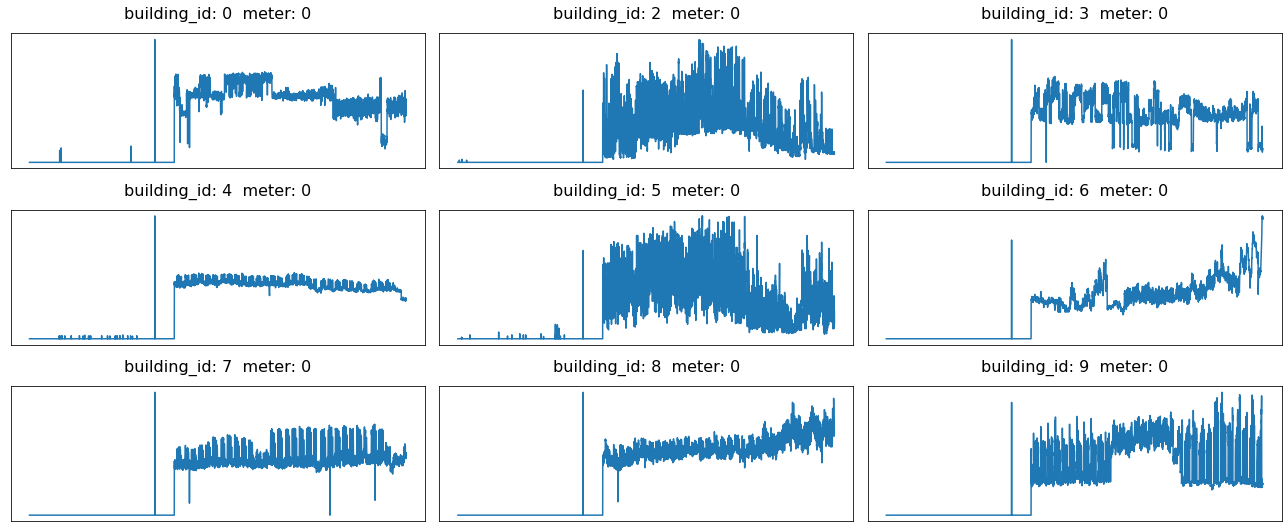

In [10]:
plot_lines(train, [0, 2, 3, 4, 5, 6, 7, 8, 9])

In [11]:
building_ids = train[train.site_id == 0].building_id.unique()
train = filter_groups(train, building_ids, 0, partial(remove_bad_start, n_values_to_keep=5400))

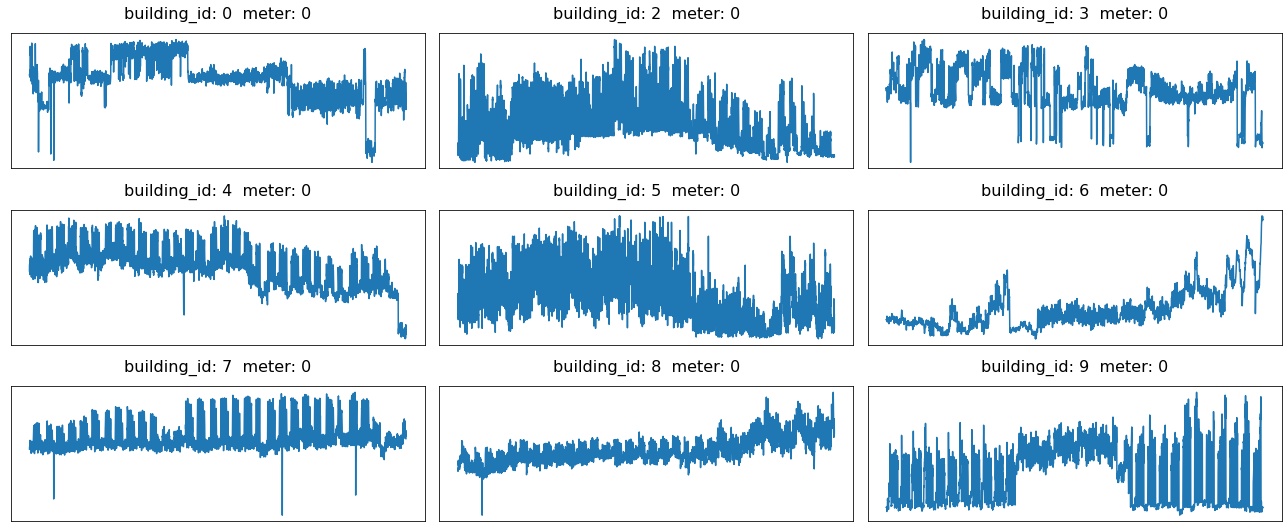

In [12]:
plot_lines(train, [0, 2, 3, 4, 5, 6, 7, 8, 9])

That looks much better. This type of anomaly doesn't occur in the same way for any other `site_id` and `meter`

### Removing continous values for `site_id:1` and `meter:0`

In [13]:
building_ids = train[train.site_id == 1].building_id.unique()

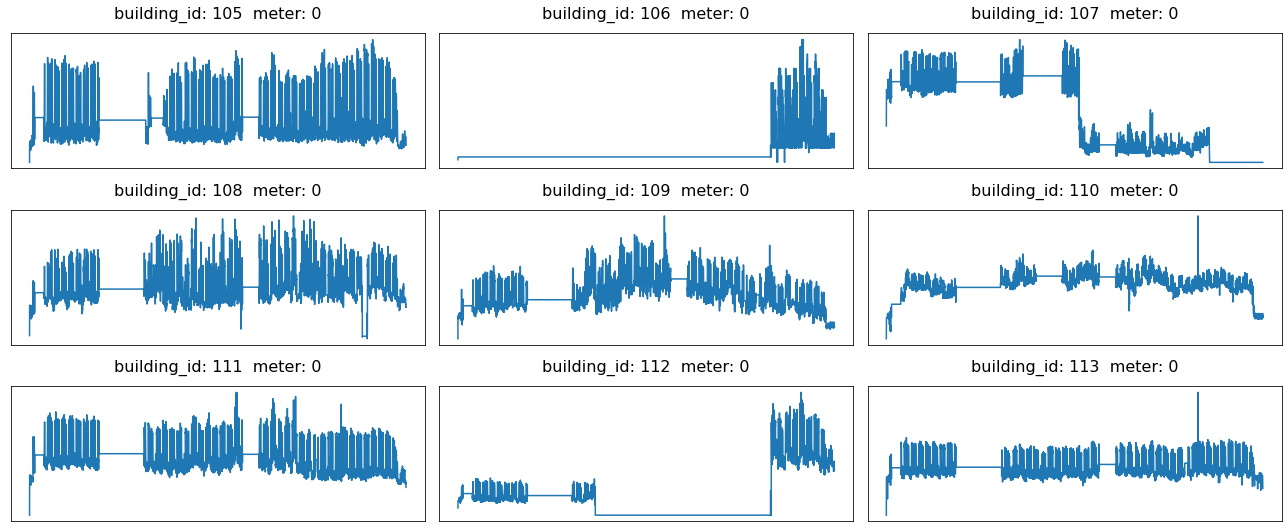

In [15]:
plot_lines(train, building_ids[:9])

In [16]:
train = filter_groups(train, building_ids, 0, partial(remove_constants, constant_length=50))

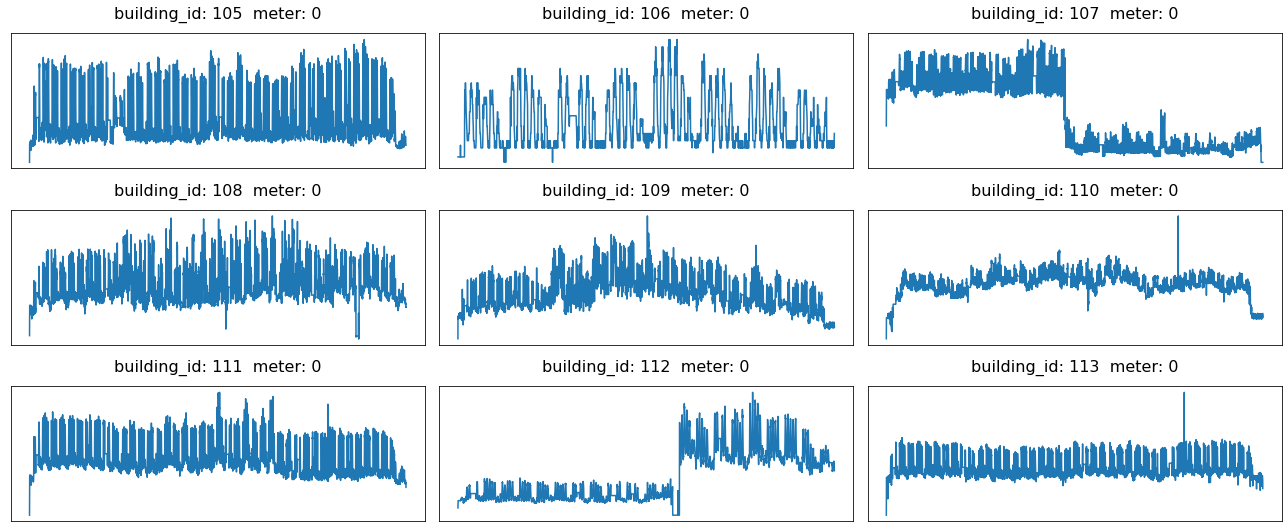

In [17]:
plot_lines(train, building_ids[:9])

Also a clear improvement

### Removing sequences of zeros for `meter:0`

Meter 0 measures electricity and it seems unlikely that there will be long gaps where zero electricity is consumed, so let's remove those rows as well.

In [18]:
building_ids = train.building_id.unique()
train = filter_groups(train, building_ids, 0, partial(remove_zeros, zero_length=50))

In [19]:
train.shape

(19589463, 20)

In [21]:
filter_groups(train, building_ids, 1, partial(remove_constants, constant_length=200)).shape

(19188264, 20)

Last but not least, let's sort the training data by timestamp

In [26]:
train = train.sort_values('timestamp')

---
# Modelling

There are hundreds of ways to build a machine learning algorithm for this data. I tried several different approaches and, initialy, I got the best results by building one model for each combination of `building_id` and `meter`, and for each combination of `site_id` and `meter`.

However, after some time, I realized that the reason why my single model solution didn't work was that I had forgotten to use `meter` as a feature which obviously led to poor result. After fixing that bug, I got almost identical performance on the kaggle test-data with both approaches (even if I still performed worse on validation).

I decided to go with the single model approach because a simple solution is always better if the performance is undistinguishable. It's also faster to train one algorithm for the entire dataset compared to thousands of small ones for the different combinations.

## Metric for evaluation

I will use RMSLE to evaluate the algorithm because that's what they use in the kaggle competition. I think that the reason why they use RMSLE instead of RMSE is that there are massive spikes and other anomalies that would take over if they didn't downplayed their role.

## Choice of algorithm

In machine learning most algorithms learn something but you want to pick one that's suits your data. Since I don't use the data as a time-series, I don't see the need for using neural networks. Instead I decided to focus on tabular data with both numerical and categorical features.Decision trees are perfect for that kind of situation.

When it comes to decision trees, I decided to use Gradient Boosted Decision Trees (or GBDT). It becomes an ensamble where each new tree tries to correct the mistakes of the last one using gradient descent. In almost every Kaggle competition that doesn't involve deep learning, GBDT is part of the winning solution.

There are a couple of good libraries to create GBDTs. I use on of the two most popular alternatives called lightGBM.

## Splitting the data

During training, I sort the data on `timestamp` and split it into two parts of equal size (past & future). Since I don't treat the data as sequences during training, I train a model on both parts and validates on the other. 

In [92]:
def train_and_predict(train, valid, test, col, cat, lgb_params, verbose=100, predict=True):
    
    lgb_train = lgb.Dataset(train[col], label=np.log1p(train.meter_reading), categorical_feature=cat)
    lgb_valid = lgb.Dataset(valid[col], label=np.log1p(valid.meter_reading), categorical_feature=cat)
    
    model = lgb.train(
        lgb_params, lgb_train, valid_sets=(lgb_train, lgb_valid), valid_names=('train', 'valid'),
        verbose_eval=verbose, early_stopping_rounds=100, num_boost_round=10000
    )
    
    if not predict:
        return model
    
    predictions_valid = valid[['row_id', 'meter_reading']]
    predictions_valid['meter_prediction'] = np.expm1(model.predict(valid[col], num_iteration=model.best_iteration))
    
    predictions_test = test[['row_id']]    
    predictions_test['meter_reading'] = np.expm1(model.predict(test[col], num_iteration=model.best_iteration))
    return model, predictions_valid, predictions_test

## Selecting features

I want my finished algorithm to be as simple as possible without damaging performance to much, that includes using fewer features. Fewer features also leads to faster training and makes it easier to search for optimal hyper-parameters. To select features, I'll start by training algorithms on with all features, compare feature importance, and remove the features with low importance before going to the next step.

I'll start with a very simple set of parameters.

In [43]:
lgb_params = {
    'num_leaves': 128,
    'min_data_in_leaf': 500,
    'metric': "rmse",
    'verbose': -1,
}

In [44]:
cat = ['building_id', 'site_id', 'meter', 'primary_use', 'hour', 'weekday', 'is_holiday']
col = cat + [
    'square_feet', 'year_built', 'floor_count', 'air_temperature', 
    'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 
    'sea_level_pressure', 'wind_direction', 'wind_speed'
]

I split the data as described above and trains two algorithms. I then average their predictions on the relevant rows on the test dataset (the rows with the same `building_id` and `meter`).

In [45]:
train_df, valid_df = train[:int(len(train) / 2)], train[int(len(train) / 2):]
    
model_1, _ = train_and_predict(train_df, valid_df, None, col, cat, lgb_params)
model_2, _ = train_and_predict(valid_df, train_df, None, col, cat, lgb_params)

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.751557	valid's rmse: 1.07053
Early stopping, best iteration is:
[87]	train's rmse: 0.762686	valid's rmse: 1.06986
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.763372	valid's rmse: 1.06546
[200]	train's rmse: 0.723796	valid's rmse: 1.0653
Early stopping, best iteration is:
[146]	train's rmse: 0.738592	valid's rmse: 1.06422


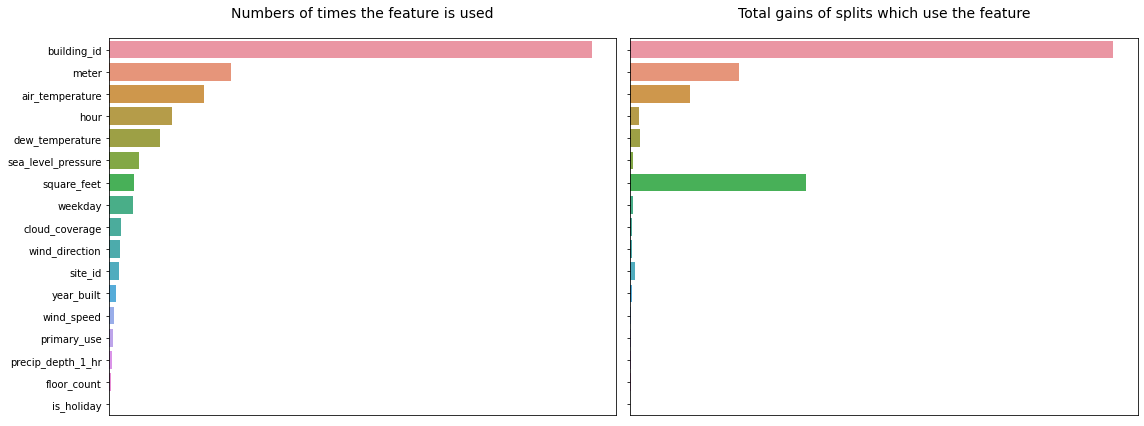

In [49]:
importance_split = np.mean([
    model_1.feature_importance(importance_type='split'),
    model_2.feature_importance(importance_type='split')
], axis=0)

importance_gain = np.mean([
    model_1.feature_importance(importance_type='gain'),
    model_2.feature_importance(importance_type='gain')
], axis=0)

importance = [(f, s, g) for f, s, g in zip(col, importance_split, importance_gain)]
importance.sort(key=lambda x: x[1], reverse=True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), sharey=True)

sns.barplot(x=[i[1] for i in importance], y=[i[0] for i in importance], ax=axes[0])
sns.barplot(x=[i[2] for i in importance], y=[i[0] for i in importance], ax=axes[1])
axes[0].set_xticks([]) ; axes[1].set_xticks([])
axes[0].set_title('Numbers of times the feature is used', y=1.04, fontsize=14)
axes[1].set_title('Total gains of splits which use the feature', y=1.04, fontsize=14)

plt.tight_layout()
plt.show()

It's not obvious where to draw the line, but it's clear that `building_id` and `meter` are the two most important features, which is expected. Everything down to `weekday` looks pretty important. We can also keep `site_id` since it has higher gain than `weekday` and `sea_level_preassure`.

In [50]:
cat = ['building_id', 'site_id', 'meter', 'hour', 'weekday']
col = cat + ['square_feet', 'air_temperature', 'dew_temperature', 'sea_level_pressure']

## Selecting hyperparameters

One problem with lightGBM is that there are hundreds of hyper-parameters that you can tune to squeeze out the last ounces of performance from your algorithm. Doing a grid-search over all of them would be very time-consuming, so I've selected a couple of parameters that I want to focus on:

- **`num_leaves`** - How many leaves a tree can have
- **`bagging_fraction`** - How many data-points each tree can look at
- **`feature_fraction`** - How many features each tree can use
- **`min_data_in_leaf`** - The minimum number of data-points in a node

To save time, and since these hyper-parameters are pretty independent of each other, I'll test a couple of values for each of them instad of doing a grid-seach. I'm aware that I'm likely to find a local optimum, but I don't want to spend to much time on hyper-parameters, because it's a massive timesink.

In [55]:
starting_parameters = {
    'num_leaves': 256,
    'min_data_in_leaf': 32,
    'bagging_fraction': 0.5,
    'feature_fraction': 0.5,
    'bagging_freq': 1,
    'metric': "rmse",
    'verbose': -1,
}

### `num_leaves`

In [72]:
for num_leaves in [256, 512, 1024, 2048]:
    lgb_params = {**starting_parameters, 'num_leaves': num_leaves}
    train_df, valid_df = train[:int(len(train) / 2)], train[int(len(train) / 2):]
    model_1 = train_and_predict(train_df, valid_df, None, col, cat, lgb_params, verbose=0, predict=False)
    model_2 = train_and_predict(valid_df, train_df, None, col, cat, lgb_params, verbose=0, predict=False)
    
    print('{}: {}'.format(num_leaves, round(np.mean([
        model_1.best_score['valid']['rmse'], model_2.best_score['valid']['rmse']
    ]), 4)))

128: 1.0792
256: 1.0743
512: 1.0695
1024: 1.0664


In [73]:
starting_parameters['num_leaves'] = 1.0664

### `min_data_in_leaf`

In [76]:
for min_data_in_leaf in [32, 64, 128, 256, 512, 1024]:
    lgb_params = {**starting_parameters, 'min_data_in_leaf': min_data_in_leaf}
    train_df, valid_df = train[:int(len(train) / 2)], train[int(len(train) / 2):]
    model_1, _ = train_and_predict(train_df, valid_df, None, col, cat, lgb_params, verbose=0)
    model_2, _ = train_and_predict(valid_df, train_df, None, col, cat, lgb_params, verbose=0)
    
    print('{}: {}'.format(min_data_in_leaf, round(np.mean([
        model_1.best_score['valid']['rmse'], model_2.best_score['valid']['rmse']
    ]), 4)))

32: 1.0695
64: 1.0705
128: 1.0691
256: 1.0682
512: 1.0658
1024: 1.0659


In [77]:
starting_parameters['min_data_in_leaf'] = 512

### `bagging_fraction`

In [78]:
for bagging_fraction in [0.2, 0.4, 0.6, 0.8, 1.0]:
    lgb_params = {**starting_parameters, 'bagging_fraction': bagging_fraction}
    train_df, valid_df = train[:int(len(train) / 2)], train[int(len(train) / 2):]
    model_1, _ = train_and_predict(train_df, valid_df, None, col, cat, lgb_params, verbose=0)
    model_2, _ = train_and_predict(valid_df, train_df, None, col, cat, lgb_params, verbose=0)
    
    print('{}: {}'.format(bagging_fraction, round(np.mean([
        model_1.best_score['valid']['rmse'], model_2.best_score['valid']['rmse']
    ]), 4)))

0.2: 1.0673
0.4: 1.0662
0.6: 1.0664
0.8: 1.0666
1.0: 1.0677


In [83]:
starting_parameters['bagging_fraction'] = 0.4

### `feature_fraction`

In [80]:
for feature_fraction in [0.4, 0.6, 0.8, 1.0]:
    lgb_params = {**starting_parameters, 'feature_fraction': feature_fraction}
    train_df, valid_df = train[:int(len(train) / 2)], train[int(len(train) / 2):]
    model_1, _ = train_and_predict(train_df, valid_df, None, col, cat, lgb_params, verbose=0)
    model_2, _ = train_and_predict(valid_df, train_df, None, col, cat, lgb_params, verbose=0)
    
    print('{}: {}'.format(feature_fraction, round(np.mean([
        model_1.best_score['valid']['rmse'], model_2.best_score['valid']['rmse']
    ]), 4)))

0.4: 1.0809
0.6: 1.0666
0.8: 1.0643
1.0: 1.0676


In [81]:
starting_parameters['feature_fraction'] = 0.8

## Submission & Result

Great! Now we have a model that we can use to make predictions on the test dataset and submit to Kaggle. Let's start by retraining the model with our new parameters, check the validation results, and make a submission. Let's start by recap our hyper-parameters and columns.

In [86]:
print('Categorical features: {}'.format(cat))
print('Numerical features: {}\n'.format([c for c in col if c not in cat]))
print('Starting parameters: {}'.format(starting_parameters))

Categorical features: ['building_id', 'site_id', 'meter', 'hour', 'weekday']
Numerical features: ['square_feet', 'air_temperature', 'dew_temperature', 'sea_level_pressure']

Starting parameters: {'num_leaves': 512, 'min_data_in_leaf': 512, 'bagging_fraction': 0.4, 'feature_fraction': 0.8, 'bagging_freq': 1, 'metric': 'rmse', 'verbose': -1}


In [93]:
model_1, P_valid_1, P_test_1 = train_and_predict(train_df, valid_df, test, col, cat, lgb_params, verbose=10)
model_2, P_valid_2, P_test_2 = train_and_predict(valid_df, train_df, test, col, cat, lgb_params, verbose=10)

Training until validation scores don't improve for 100 rounds
[10]	train's rmse: 1.16972	valid's rmse: 1.28932
[20]	train's rmse: 0.918413	valid's rmse: 1.12273
[30]	train's rmse: 0.829078	valid's rmse: 1.08442
[40]	train's rmse: 0.784628	valid's rmse: 1.07629
[50]	train's rmse: 0.751563	valid's rmse: 1.07656
[60]	train's rmse: 0.728128	valid's rmse: 1.0793
[70]	train's rmse: 0.714478	valid's rmse: 1.08335
[80]	train's rmse: 0.703282	valid's rmse: 1.0869
[90]	train's rmse: 0.696302	valid's rmse: 1.08741
[100]	train's rmse: 0.69033	valid's rmse: 1.08874
[110]	train's rmse: 0.686878	valid's rmse: 1.08932
[120]	train's rmse: 0.683814	valid's rmse: 1.0901
[130]	train's rmse: 0.681029	valid's rmse: 1.09049
[140]	train's rmse: 0.678651	valid's rmse: 1.09065
Early stopping, best iteration is:
[41]	train's rmse: 0.781403	valid's rmse: 1.07544
Training until validation scores don't improve for 100 rounds
[10]	train's rmse: 1.16995	valid's rmse: 1.28931
[20]	train's rmse: 0.922527	valid's rmse: 

### Submission

In [95]:
submission = test[['row_id']]

submission['p1'] = P_test_1.set_index('row_id')['meter_reading']
submission['p2'] = P_test_2.set_index('row_id')['meter_reading']

In [98]:
submission['meter_reading'] = ((submission.p1 + submission.p2) / 2).round().astype(int)

In [100]:
submission[['row_id', 'meter_reading']].to_csv('submission.csv', index=None)

### Results


My subbmission scored 1.09 on the public testset and 1.31 on the private testset. Unfortunatly I can't compare my results withn the leaderboard because there was a major data leakage during the competition and I decided to not use that data. Therefore my results looks quite bad. If I compare with the public kernels there are some that performs slightly better, but it's a competitive result. 

---
# Conclusion

This was a fun project where data processing was the most important part to create a good solution. There were several things that made this project different from most other datasets I've worked on.
1. First of all we had more testing data than training data, and it seems like the test-data also contains a lot of anomalies.
2. The dataset contained 1449 buildings that are independent of each other but we need to share some information in order to generalize.

I started with an approach where I developed one model for each combination of `building_id` and `meter` and it gave me much better result initialy. However, after some time, I discovered that the reason why it gave me better result was that I had a bug in my single model solution where I hadn't included `meter` as a feature.

I should have captured that sooner by understanding that the model can learn to seperate individual buildings if it has access to that information, so the results should be more similar between the two solutions than what I experienced. In the end, both gave me the same results on Kaggle, even if the single model scores worse on the validation data.